# Uplift Modeling for Churn Prediction

Short notebook: same workflow as the full notebook, using **utils** for all logic.
Run cells in order. Data paths: all files under `files/` (e.g. `files/train/`, `files/test/`, `files/wellco_client_brief.txt`).

## 1. Setup


In [73]:
# Setup may take 30–60s: utils imports sentence_transformers, causalml, lightgbm, xgboost.
from pathlib import Path
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import StratifiedKFold
try:
    from causalml.metrics import qini_auc_score
except Exception:
    qini_auc_score = None

import utils
importlib.reload(utils)  # use latest utils.py (re-run this cell after editing utils)
from utils import (  # noqa: E402 — must be after reload() so we get latest code
    approx_auuc, assign_segments, build_claims_labels, build_feature_matrix, build_recency_tenure,
    count_events_before_signup, DOW_NAMES, embed_wellco_brief, EMBED_MODEL_NAME, feat_distribution_summary,
    feature_diagnostics, FOCUS_ICD_CODES, load_wellco_brief, missingness_and_member_coverage,
    missingness_mechanism_analysis, plot_balance, plot_correlation_diagnostics, plot_feature_histograms,
    print_focus_icd_stats, print_table_overview, RANDOM_STATE, ref_date_from_tables,
    run_relevance_filter_sanity_check, run_uplift_cv, save_uplift_cv_report, select_best_uplift_model,
    SIMILARITY_THRESHOLD, summarize_uplift_cv, time_bin, uplift_at_k, uplift_by_groups, uplift_curve,
    build_model, build_uplift_cv_comparison_table, get_validation_qini_curves, plot_auuc_comparison,
    plot_uplift_at_k_comparison, plot_qini_curves_comparison,
    run_uplift_hp_grid_search, build_hp_grid_search_table, get_qini_curves_top_hp_combos,
    save_hp_grid_search_report,
)

pd.set_option('display.max_columns', 200)
# Project root (parent of src/); files/ is at project root, not inside src
BASE_DIR = Path('.').resolve().parent
FILE_DIR = BASE_DIR / 'files'  # all data files live under files/
TRAIN_DIR = FILE_DIR / 'train'
TEST_DIR = FILE_DIR / 'test'


## 2. Load data
Train/test CSVs; train events restricted to observation window (July 1–15, 2025).


In [4]:
# Training data
churn_labels = pd.read_csv(TRAIN_DIR / "churn_labels.csv", parse_dates=["signup_date"])
app_usage = pd.read_csv(TRAIN_DIR / "app_usage.csv", parse_dates=["timestamp"])
web_visits = pd.read_csv(TRAIN_DIR / "web_visits.csv", parse_dates=["timestamp"])
claims = pd.read_csv(TRAIN_DIR / "claims.csv", parse_dates=["diagnosis_date"])

# Test data
test_members = pd.read_csv(TEST_DIR / "test_members.csv", parse_dates=["signup_date"])
test_app_usage = pd.read_csv(TEST_DIR / "test_app_usage.csv", parse_dates=["timestamp"])
test_web_visits = pd.read_csv(TEST_DIR / "test_web_visits.csv", parse_dates=["timestamp"])
test_claims = pd.read_csv(TEST_DIR / "test_claims.csv", parse_dates=["diagnosis_date"])

# Observation window: July 1 - July 15, 2025 (pre-outreach). Outreach = July 15; churn measured after.
# Restrict train event data only; test data is not filtered (outreach has not occurred for test).
OBS_START = pd.Timestamp("2025-07-01")
OBS_END   = pd.Timestamp("2025-07-15")  # exclusive: keep events strictly before outreach

web_visits = web_visits[(web_visits["timestamp"] >= OBS_START) & (web_visits["timestamp"] < OBS_END)]
app_usage  = app_usage[(app_usage["timestamp"] >= OBS_START) & (app_usage["timestamp"] < OBS_END)]
claims     = claims[(claims["diagnosis_date"] >= OBS_START) & (claims["diagnosis_date"] < OBS_END)]

# Quick sanity check
for name, df in {
    "churn_labels": churn_labels,
    "app_usage": app_usage,
    "web_visits": web_visits,
    "claims": claims,
    "test_members": test_members,
    "test_app_usage": test_app_usage,
    "test_web_visits": test_web_visits,
    "test_claims": test_claims,
}.items():
    print(f"{name}: {df.shape}")

churn_labels: (10000, 4)
app_usage: (97789, 3)
web_visits: (259340, 5)
claims: (64576, 3)
test_members: (10000, 2)
test_app_usage: (97961, 3)
test_web_visits: (261729, 5)
test_claims: (64803, 3)


## **3. EDA**

Exploratory data analysis: table structure, missingness, treatment balance, leakage checks, and uplift by engagement/claims/recency.

---

### **3.1 Raw data overview**
Summarize structure, dtypes, and sample rows for all 8 tables.


In [5]:
all_tables = {
    "churn_labels": churn_labels,
    "app_usage": app_usage,
    "web_visits": web_visits,
    "claims": claims,
    "test_members": test_members,
    "test_app_usage": test_app_usage,
    "test_web_visits": test_web_visits,
    "test_claims": test_claims,
}

for name, df in all_tables.items():
    print_table_overview(name, df)



  churn_labels

--- dtypes ---
member_id               int64
signup_date    datetime64[ns]
churn                   int64
outreach                int64

--- describe (numeric columns only) ---
              churn      outreach
count  10000.000000  10000.000000
mean       0.202100      0.398400
std        0.401587      0.489593
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      1.000000
max        1.000000      1.000000

--- date ranges ---
  signup_date: 2024-01-01 00:00:00 to 2025-05-31 00:00:00

--- head(2) ---


,member_id,signup_date,churn,outreach
0,1,2024-04-12,0,0
1,2,2025-03-11,0,0



  app_usage

--- dtypes ---
member_id              int64
event_type            object
timestamp     datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:00 to 2025-07-14 23:59:51

--- object columns (unique counts) ---
  event_type: 1 unique values

--- head(2) ---


,member_id,event_type,timestamp
0,1,session,2025-07-13 08:43:37
1,1,session,2025-07-14 15:28:58



  web_visits

--- dtypes ---
member_id               int64
url                    object
title                  object
description            object
timestamp      datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:01 to 2025-07-14 23:59:49

--- object columns (unique counts) ---
  url: 69894 unique values
  title: 26 unique values
  description: 26 unique values

--- head(2) ---


,member_id,url,title,description,timestamp
0,1,https://health.wellco/chronic/859,Diabetes management,Blood sugar and glycemic control,2025-07-02 22:38:22
1,1,https://portal.site/tech/328,Gadget roundup,Smartphones and laptops news,2025-07-02 11:30:47



  claims

--- dtypes ---
member_id                  int64
icd_code                  object
diagnosis_date    datetime64[ns]

--- date ranges ---
  diagnosis_date: 2025-07-01 00:00:00 to 2025-07-14 00:00:00

--- object columns (unique counts) ---
  icd_code: 10 unique values

--- head(2) ---


,member_id,icd_code,diagnosis_date
0,1,Z71.3,2025-07-09
1,1,Z71.3,2025-07-14



  test_members

--- dtypes ---
member_id               int64
signup_date    datetime64[ns]

--- date ranges ---
  signup_date: 2024-01-01 00:00:00 to 2025-05-31 00:00:00

--- head(2) ---


,member_id,signup_date
0,20001,2024-11-16
1,20002,2024-09-12



  test_app_usage

--- dtypes ---
member_id              int64
event_type            object
timestamp     datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:14 to 2025-07-14 23:59:56

--- object columns (unique counts) ---
  event_type: 1 unique values

--- head(2) ---


,member_id,event_type,timestamp
0,20001,session,2025-07-05 07:03:13
1,20001,session,2025-07-05 20:10:22



  test_web_visits

--- dtypes ---
member_id               int64
url                    object
title                  object
description            object
timestamp      datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:00 to 2025-07-14 23:59:47

--- object columns (unique counts) ---
  url: 69982 unique values
  title: 26 unique values
  description: 26 unique values

--- head(2) ---


,member_id,url,title,description,timestamp
0,20001,https://care.portal/fitness/812,Exercise routines,Cardio and strength workouts,2025-07-09 18:30:35
1,20001,https://media.hub/sports/478,Match highlights,League standings and transfers,2025-07-04 05:25:38



  test_claims

--- dtypes ---
member_id                  int64
icd_code                  object
diagnosis_date    datetime64[ns]

--- date ranges ---
  diagnosis_date: 2025-07-01 00:00:00 to 2025-07-14 00:00:00

--- object columns (unique counts) ---
  icd_code: 10 unique values

--- head(2) ---


,member_id,icd_code,diagnosis_date
0,20001,E11.9,2025-07-06
1,20001,H10.9,2025-07-14


### 3.2 Column-specific checks
event_type, url, title, icd_code for feature-engineering decisions.


In [6]:
# ----------
# 3.1 Column-specific checks
# Purpose: Check special columns (event_type, url, title, icd_code) for feature engineering decisions.
# What we test: value_counts for event_type, url, title, icd_code.
# What we do with this info:
#   - If event_type is constant -> drop it.
#   - URL/title variety -> potential content-categorization features.
#   - ICD distribution -> guides focus-ICD flag design.
# ----------

print("="*60)
print("  Column-specific checks")
print("="*60)
print("\napp_usage event_type value_counts:")
print(app_usage["event_type"].value_counts().to_string())
print(f"  -> {'CONSTANT — can drop' if app_usage['event_type'].nunique() == 1 else 'MULTIPLE VALUES — keep'}")

# url and title in web_visits: content variety
print(f"\nweb_visits url: {web_visits['url'].nunique()} unique values")
print("  Top-5 URLs:")
print(web_visits["url"].value_counts().head(5).to_string())
print(f"\nweb_visits title: {web_visits['title'].nunique()} unique values")
print("  Top-5 titles:")
print(web_visits["title"].value_counts().head(5).to_string())

# icd_code in claims
print(f"\nclaims icd_code: {claims['icd_code'].nunique()} unique values")
print("  Top-10 ICD codes:")
print(claims["icd_code"].value_counts().head(10).to_string())

  Column-specific checks

app_usage event_type value_counts:
event_type
session    97789
  -> CONSTANT — can drop

web_visits url: 69894 unique values
  Top-5 URLs:
url
https://portal.site/gaming/682    18
https://example.com/gaming/283    18
https://media.hub/movies/434      18
https://media.hub/cars/275        18
https://world.news/sports/764     17

web_visits title: 26 unique values
  Top-5 titles:
title
Top destinations     22600
Gadget roundup       22553
Electric vehicles    22395
New releases         22271
Match highlights     22257

claims icd_code: 10 unique values
  Top-10 ICD codes:
icd_code
Z71.3    9145
I10      9006
E11.9    8961
H10.9    5414
B34.9    5410
A09      5387
M54.5    5385
J00      5346
R51      5277
K21.9    5245


### 3.3 Missing values and member coverage


  Part A — Column-level null check

✓ No null values found in any column of any table.

  Part B — Member coverage across sources

--- TRAIN (base members: 10000) ---
    source  members_present  members_absent  absent_pct
web_visits             9975              25        0.25
 app_usage             9998               2        0.02
    claims             9980              20        0.20

Cross-source missingness patterns (train):
  missing web only: 25 (0.25%)
  missing app only: 2 (0.02%)
  missing claims only: 20 (0.20%)
  missing web+app: 0 (0.00%)
  missing web+claims: 0 (0.00%)
  missing app+claims: 0 (0.00%)
  missing all 3: 0 (0.00%)
  present in all: 9953 (99.53%)


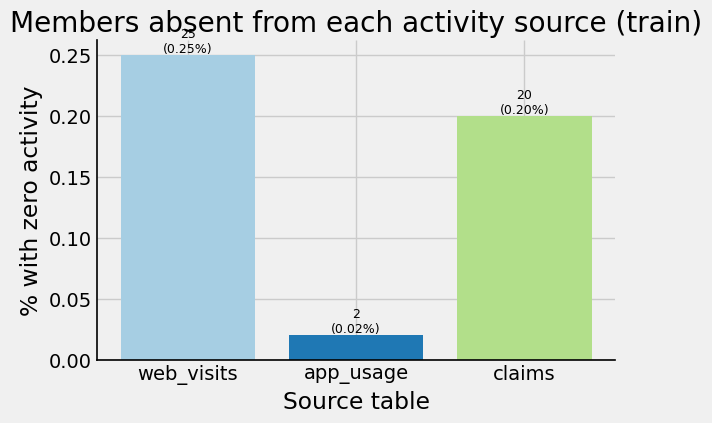


--- TEST (base members: 10000) ---
    source  members_present  members_absent  absent_pct
web_visits             9981              19        0.19
 app_usage             9998               2        0.02
    claims             9978              22        0.22


In [7]:
# 3.2 Missing values and member coverage (utils: missingness_and_member_coverage)
missingness_and_member_coverage(all_tables, churn_labels, web_visits, app_usage, claims, test_members, test_web_visits, test_app_usage, test_claims)

### 3.4 Missingness mechanism (Chi-square)


  Chi-square tests: churn/outreach rate by presence/absence
source_flag   target  rate_absent (0)  rate_present (1)  chi2 p_value
    has_web    churn             0.08            0.2024  1.62  0.2031
    has_web outreach             0.60            0.3979  3.45 0.06331
    has_app    churn             0.50            0.2020  0.03   0.866
    has_app outreach             1.00            0.3983  1.03  0.3097
 has_claims    churn             0.30            0.2019  0.66  0.4164
 has_claims outreach             0.40            0.3984  0.00       1

  Cross-source contingency (train)
 has_web  has_app  has_claims  count
       0        1           1     25
       1        0           1      2
       1        1           0     20
       1        1           1   9953


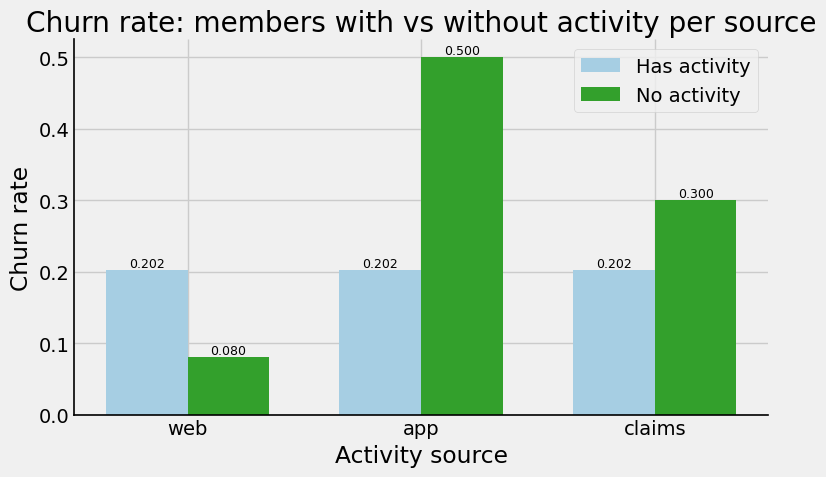

In [8]:
# 3.4 Missingness mechanism (utils: missingness_mechanism_analysis)
missingness_mechanism_analysis(churn_labels, web_visits, app_usage, claims)

**What it means:** Chi-square p-values and the bar chart show whether churn (or outreach) rate differs between members who have activity in a source vs those who do not. The cross-tab shows how many members are missing from each combination of sources.

**What it says about further analysis:**  p-values are large (e.g. > 0.05), missingness is not strongly related to churn/outreach → zero-fill is enough.

### 3.5 Labels & treatment balance

Overall churn rate: 0.202
Outreach rate: 0.398

Outreach x Churn cross-tabulation:
churn        0     1  Total
outreach                   
0         4768  1248   6016
1         3211   773   3984
Total     7979  2021  10000

Churn rates by group:
          members  churn_rate
outreach                     
0            6016    0.207447
1            3984    0.194026


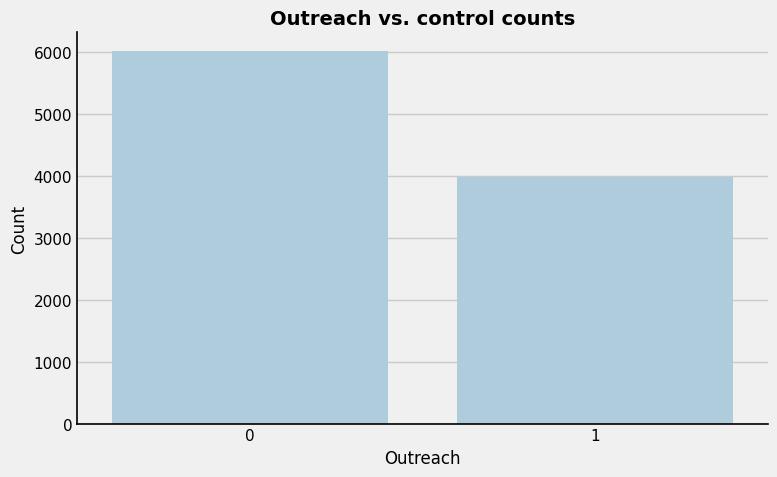

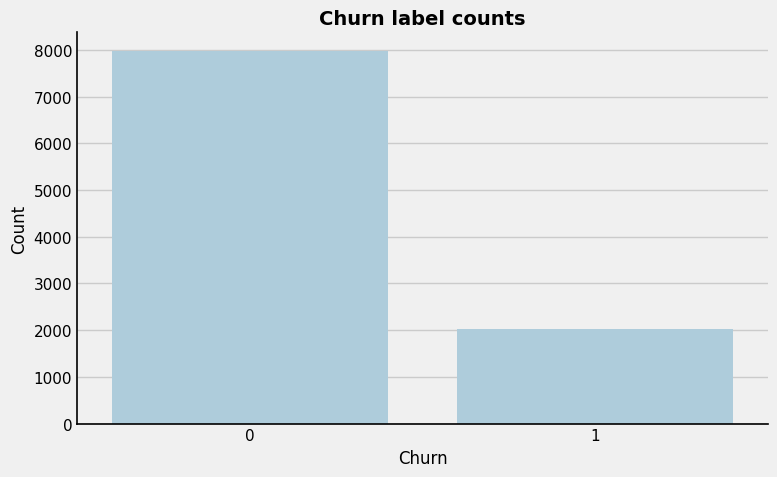

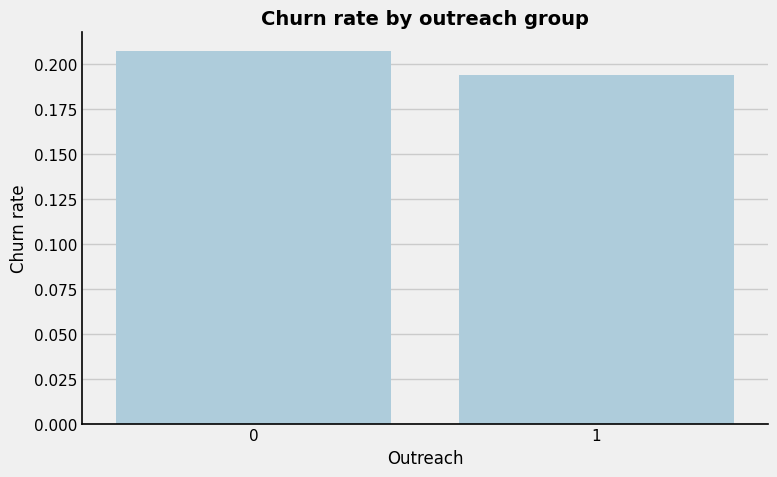

In [9]:
# 3.4 Labels and treatment balance
churn_rate = churn_labels["churn"].mean()
outreach_rate = churn_labels["outreach"].mean()

summary_labels = churn_labels.groupby("outreach")["churn"].agg([
    ("members", "count"),
    ("churn_rate", "mean"),
])

print(f"Overall churn rate: {churn_rate:.3f}")
print(f"Outreach rate: {outreach_rate:.3f}")
print("\nOutreach x Churn cross-tabulation:")
cross_tab = pd.crosstab(churn_labels["outreach"], churn_labels["churn"],
                        margins=True, margins_name="Total")
print(cross_tab.to_string())
print("\nChurn rates by group:")
print(summary_labels.to_string())

plot_balance(churn_labels, "outreach", "Outreach vs. control counts", "Outreach", "Count")
plot_balance(churn_labels, "churn", "Churn label counts", "Churn", "Count")
plot_balance(summary_labels.reset_index(), "outreach", "Churn rate by outreach group", "Outreach", "Churn rate", y="churn_rate")


### 3.6 Leakage & time-window validation


In [10]:
window_summary = pd.DataFrame([
    {'table': 'web_visits', 'min': web_visits['timestamp'].min(), 'max': web_visits['timestamp'].max()},
    {'table': 'app_usage', 'min': app_usage['timestamp'].min(), 'max': app_usage['timestamp'].max()},
    {'table': 'claims', 'min': claims['diagnosis_date'].min(), 'max': claims['diagnosis_date'].max()},
])
leakage = pd.DataFrame([
    {'table': 'web_visits', 'events_before_signup': count_events_before_signup(web_visits, 'timestamp', churn_labels)},
    {'table': 'app_usage', 'events_before_signup': count_events_before_signup(app_usage, 'timestamp', churn_labels)},
    {'table': 'claims', 'events_before_signup': count_events_before_signup(claims, 'diagnosis_date', churn_labels)},
])
display(window_summary)
display(leakage)

,table,min,max
0,web_visits,2025-07-01 00:00:01,2025-07-14 23:59:49
1,app_usage,2025-07-01 00:00:00,2025-07-14 23:59:51
2,claims,2025-07-01 00:00:00,2025-07-14 00:00:00


,table,events_before_signup
0,web_visits,0
1,app_usage,0
2,claims,0


**What it means:** The first table shows min/max timestamps per event table (all within July 1–14, 2025). The second table shows zero events before signup for web, app, and claims — no leakage.

**What it says about further analysis:** Observation window and signup logic are consistent. We can safely use these events for feature engineering. Next: temporal and engagement uplift (3.6, 3.7).

### 3.7 Temporal features as uplift moderators

Uplift = P(churn=1 | outreach=1, bin) − P(churn=1 | outreach=0, bin).

Each bar shows uplift among members who had **at least one event** in that bin. The same member may appear in multiple bins.


In [11]:
web_ev = web_visits[['member_id', 'timestamp']].copy(); web_ev['hour'] = web_ev['timestamp'].dt.hour; web_ev['dow'] = web_ev['timestamp'].dt.dayofweek
app_ev = app_usage[['member_id', 'timestamp']].copy(); app_ev['hour'] = app_ev['timestamp'].dt.hour; app_ev['dow'] = app_ev['timestamp'].dt.dayofweek

events = pd.concat([web_ev[['member_id', 'hour', 'dow']], app_ev[['member_id', 'hour', 'dow']]], ignore_index=True)
events['time_of_day'] = events['hour'].apply(time_bin)
events['dow_name'] = events['dow'].map(DOW_NAMES)
events['is_weekend'] = events['dow'].isin([5, 6])
labels = churn_labels[['member_id', 'churn', 'outreach']]
print('Events:', len(events), 'rows,', events['member_id'].nunique(), 'members')

Events: 357129 rows, 10000 members


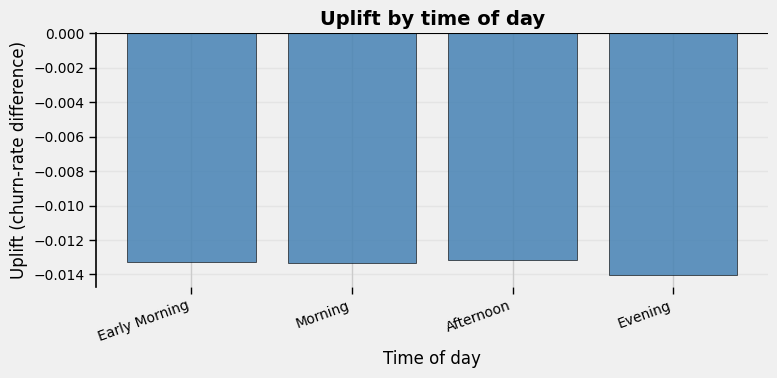

Group                       Uplift  n_treated  n_control
Early Morning              -0.0133       3967       5997
Morning                    -0.0133       3969       6003
Afternoon                  -0.0131       3961       5992
Evening                    -0.0140       3966       5998


In [12]:
# Uplift by time of day
uplift_by_groups(events, labels, "time_of_day", ["Early Morning", "Morning", "Afternoon", "Evening"], title="Uplift by time of day", xlabel="Time of day")


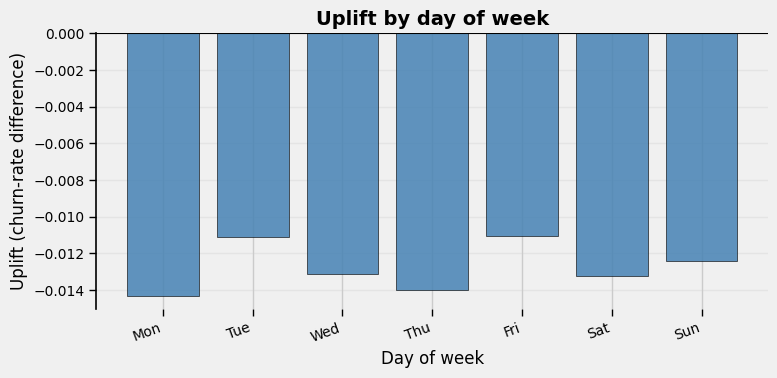

Group                       Uplift  n_treated  n_control
Mon                        -0.0143       3859       5849
Tue                        -0.0111       3867       5854
Wed                        -0.0131       3870       5867
Thu                        -0.0140       3880       5870
Fri                        -0.0110       3875       5851
Sat                        -0.0132       3882       5871
Sun                        -0.0124       3869       5847


In [13]:
# Uplift by day of week
uplift_by_groups(events, labels, "dow_name", ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], title="Uplift by day of week", xlabel="Day of week")


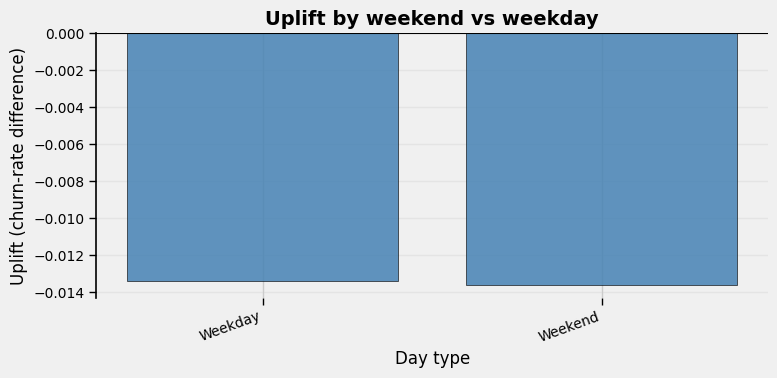

Group                       Uplift  n_treated  n_control
Weekday                    -0.0134       3984       6016
Weekend                    -0.0136       3973       6007


In [14]:
# Uplift by weekend vs weekday
uplift_by_groups(events, labels, "is_weekend", [False, True], plot_labels=["Weekday", "Weekend"], title="Uplift by weekend vs weekday", xlabel="Day type")


**What it means:** Uplift by time of day and by weekday vs weekend is similar across bins (all slightly negative). Outreach reduces churn a bit regardless of when members are active.

**What it says about further analysis:** Temporal features (time of day, day of week, weekend) do not strongly moderate uplift. Next: engagement and claims

### 3.8 Engagement features as uplift moderators

**(a)** Distribution sanity checks — log-scaled histograms and quantile summaries.  
**(b)** Uplift by engagement quartile for each feature.

Raw web_visits: 259340 rows.
Within-member revisits: 85 duplicate (member_id, url) rows (same member, same URL > once).
Members with web_visits_count != url_nunique: 84 (expected > 0 when revisits exist).
Example: member_id=3, url='https://portal.site/pets/371' (visited 2 times).

web_visits_count vs url_nunique (should differ where revisits exist):
      web_visits_count  url_nunique
0.00               0.0          0.0
0.25              13.0         13.0
0.50              22.0         22.0
0.75              35.0         35.0
1.00             140.0        140.0
Difference (web_visits_count - url_nunique): min=0.0, max=2.0, members with diff>0: 84.

web_visits_count:
0.00      0.00
0.25     13.00
0.50     22.00
0.75     35.00
0.90     49.00
0.95     59.05
0.99     81.00
1.00    140.00


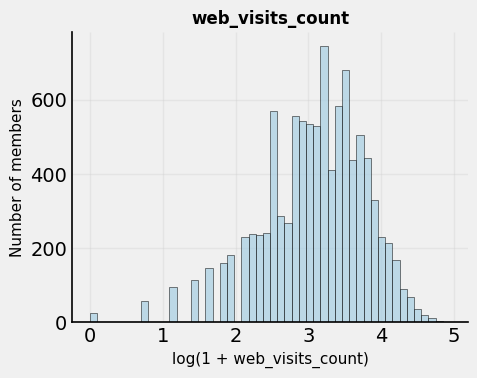


app_sessions_count:
0.00     0.0
0.25     7.0
0.50    10.0
0.75    12.0
0.90    15.0
0.95    16.0
0.99    19.0
1.00    26.0


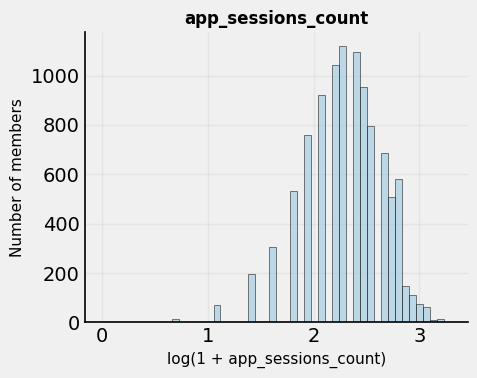


url_nunique:
0.00      0.0
0.25     13.0
0.50     22.0
0.75     35.0
0.90     49.0
0.95     59.0
0.99     81.0
1.00    140.0


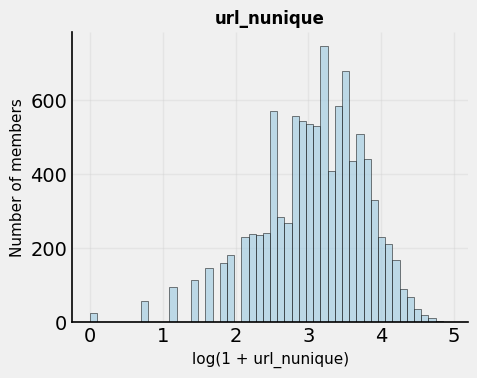

In [15]:
# Distribution sanity checks (engagement)

web_per = web_visits.groupby("member_id").size().rename("web_visits_count").reset_index()
app_per = app_usage.groupby("member_id").size().rename("app_sessions_count").reset_index()
url_div = web_visits.groupby("member_id")["url"].nunique().rename("url_nunique").reset_index()

eng = churn_labels[["member_id", "churn", "outreach"]].merge(
    web_per, on="member_id", how="left"
).merge(
    app_per, on="member_id", how="left"
).merge(
    url_div, on="member_id", how="left"
)
for col in ["web_visits_count", "app_sessions_count", "url_nunique"]:
    eng[col] = eng[col].fillna(0)

# Sanity: web_visits_count = rows per member, url_nunique = distinct URLs per member.
# We count only within-member revisits: same (member_id, url) more than once.
# (Duplicate URLs across the table are expected — many members can visit the same URL.)
n_within_member_dupes = len(web_visits) - web_visits.drop_duplicates(subset=["member_id", "url"]).shape[0]
n_members_differ = (eng["web_visits_count"] != eng["url_nunique"]).sum()
print(f"Raw web_visits: {len(web_visits)} rows.")
print(f"Within-member revisits: {n_within_member_dupes} duplicate (member_id, url) rows (same member, same URL > once).")
print(f"Members with web_visits_count != url_nunique: {n_members_differ} (expected > 0 when revisits exist).")
# One example: (member_id, url) that appears more than once
revisit_counts = web_visits.groupby(["member_id", "url"]).size()
revisited_pairs = revisit_counts[revisit_counts > 1]
if len(revisited_pairs) > 0:
    example_mid, example_url = revisited_pairs.index[0]
    n_times = revisited_pairs.iloc[0]
    print(f"Example: member_id={example_mid}, url={example_url!r} (visited {n_times} times).")

# Show that the two metrics differ: side-by-side quantiles and difference (revisits add to count but not to nunique)
diff = eng["web_visits_count"] - eng["url_nunique"]
print("\nweb_visits_count vs url_nunique (should differ where revisits exist):")
print(pd.DataFrame({
    "web_visits_count": eng["web_visits_count"].quantile([0, 0.25, 0.5, 0.75, 1]),
    "url_nunique": eng["url_nunique"].quantile([0, 0.25, 0.5, 0.75, 1]),
}).to_string())
print(f"Difference (web_visits_count - url_nunique): min={diff.min()}, max={diff.max()}, members with diff>0: {(diff > 0).sum()}.")

feat_distribution_summary(eng, "web_visits_count")
feat_distribution_summary(eng, "app_sessions_count")
feat_distribution_summary(eng, "url_nunique")


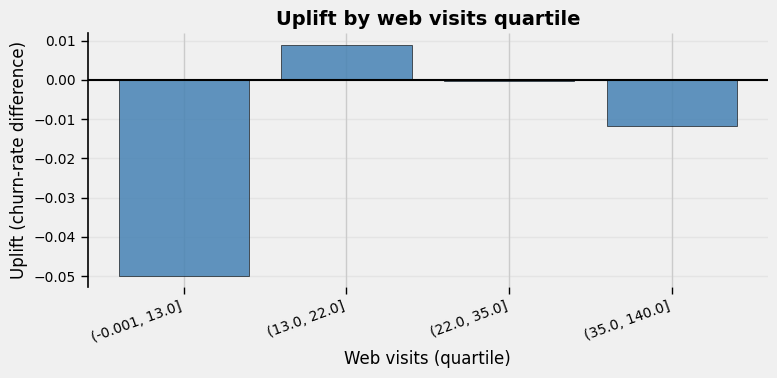

Group                       Uplift  n_treated  n_control
(-0.001, 13.0]             -0.0498       1028       1560
(13.0, 22.0]                0.0089        962       1471
(22.0, 35.0]               -0.0003        991       1582
(35.0, 140.0]              -0.0117       1003       1403


In [16]:
# Uplift by web_visits_count quartile
eng["web_q"] = pd.qcut(eng["web_visits_count"], q=4, duplicates="drop")
uplift_by_groups(eng, labels, "web_q", sorted(eng["web_q"].dropna().unique()), title="Uplift by web visits quartile", xlabel="Web visits (quartile)")


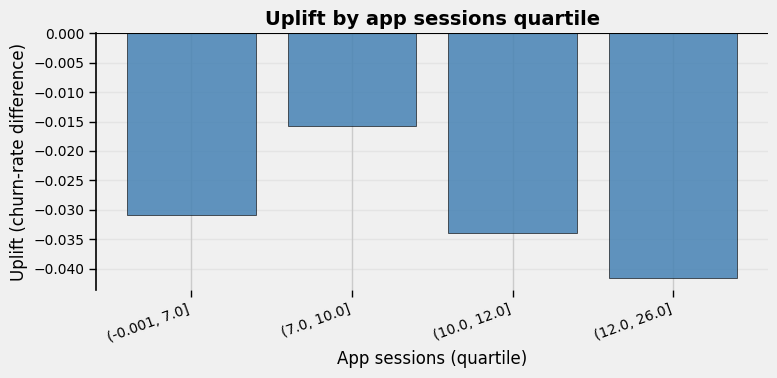

Group                       Uplift  n_treated  n_control
(-0.001, 7.0]              -0.0309       1512       1285
(7.0, 10.0]                -0.0158       1357       1899
(10.0, 12.0]               -0.0340        585       1166
(12.0, 26.0]               -0.0416        530       1666


In [17]:
# Uplift by app_sessions_count quartile
eng["app_q"] = pd.qcut(eng["app_sessions_count"], q=4, duplicates="drop")
uplift_by_groups(eng, labels, "app_q", sorted(eng["app_q"].dropna().unique()), title="Uplift by app sessions quartile", xlabel="App sessions (quartile)")


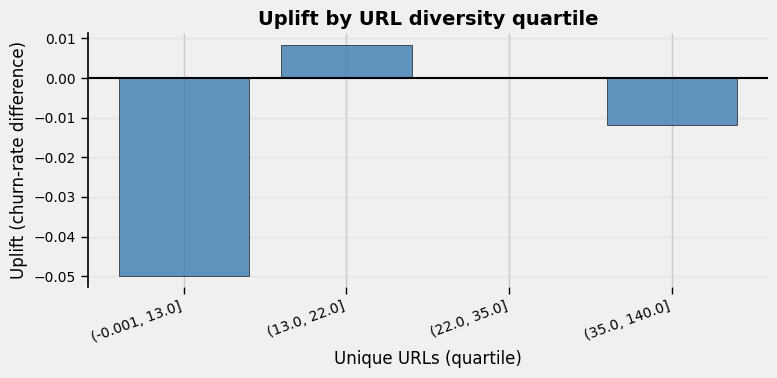

Group                       Uplift  n_treated  n_control
(-0.001, 13.0]             -0.0498       1028       1560
(13.0, 22.0]                0.0084        962       1472
(22.0, 35.0]                0.0003        991       1582
(35.0, 140.0]              -0.0119       1003       1402


In [18]:
# Uplift by URL diversity quartile
eng["url_q"] = pd.qcut(eng["url_nunique"], q=4, duplicates="drop")
uplift_by_groups(eng, labels, "url_q", sorted(eng["url_q"].dropna().unique()), title="Uplift by URL diversity quartile", xlabel="Unique URLs (quartile)")


**What it means:** Engagement (event counts, sessions) shows uplift varying by quartile; some bins have near-zero or slightly positive uplift. URL diversity and web visit counts share information - one should be chosen to avoid multicolinearity (in tree based models its not a problem)

**What it says about further analysis:** Engagement level can moderate uplift — useful as features for the model. 

### 3.9 Claims features as uplift moderators

**(a)** Distribution sanity checks — log-scaled histograms, quantile summaries, focus-ICD prevalence.  
**(b)** Uplift by claims strata: quartile bins for counts, binary for has-focus-ICD, and 0/1/2/3 for count of focus ICDs.



claims_count:
0.00     0.0
0.25     5.0
0.50     6.0
0.75     8.0
0.90    10.0
0.95    11.0
0.99    13.0
1.00    18.0


c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\src\utils.py:717: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cl["has_focus_icd"] = cl["has_focus_icd"].fillna(False).astype(int)


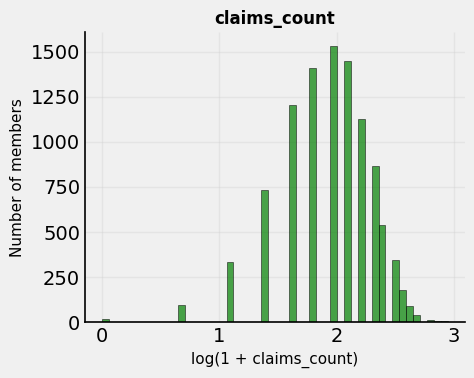


icd_nunique:
0.00     0.0
0.25     4.0
0.50     5.0
0.75     6.0
0.90     7.0
0.95     7.0
0.99     8.0
1.00    10.0


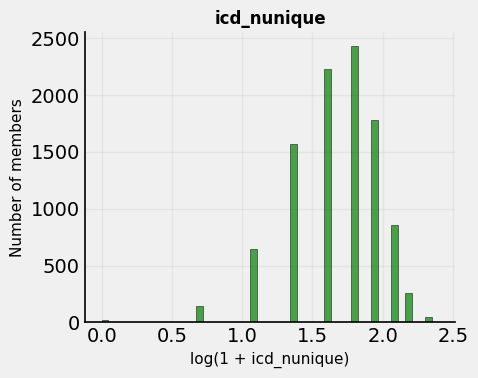


Focus-ICD prevalence: 0.925

Focus-ICD count distribution:
focus_icd_count
0     752
1    2954
2    4173
3    2121


In [19]:
# Distribution sanity checks (claims)
cl = build_claims_labels(claims, churn_labels)
feat_distribution_summary(cl, "claims_count", color="green")
feat_distribution_summary(cl, "icd_nunique", color="green")
print_focus_icd_stats(cl)


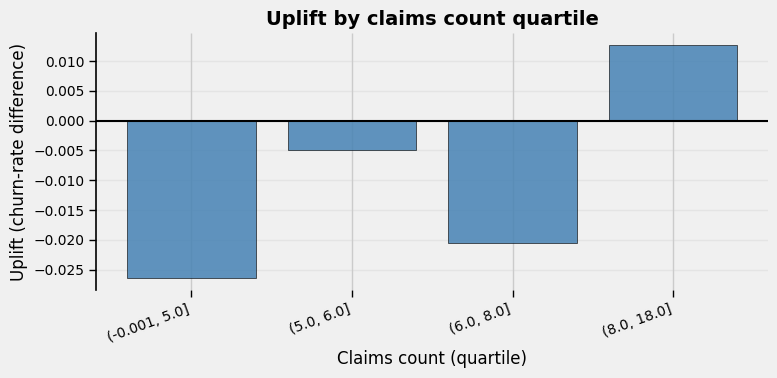

Group                       Uplift  n_treated  n_control
(-0.001, 5.0]              -0.0265       1514       2284
(5.0, 6.0]                 -0.0049        608        922
(6.0, 8.0]                 -0.0205       1028       1549
(8.0, 18.0]                 0.0127        834       1261


In [20]:
# Uplift by claims_count quartile
cl["claims_q"] = pd.qcut(cl["claims_count"], q=4, duplicates="drop")
uplift_by_groups(cl, labels, "claims_q", sorted(cl["claims_q"].dropna().unique()), title="Uplift by claims count quartile", xlabel="Claims count (quartile)")


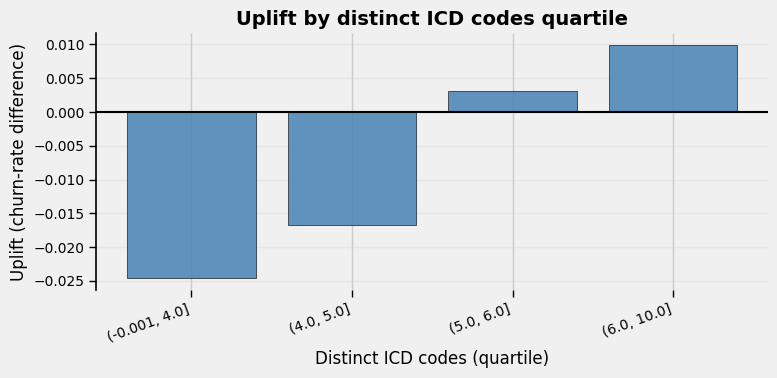

Group                       Uplift  n_treated  n_control
(-0.001, 4.0]              -0.0246       1865       2748
(4.0, 5.0]                 -0.0167        951       1480
(5.0, 6.0]                  0.0031        688       1092
(6.0, 10.0]                 0.0099        480        696


In [21]:
# Uplift by icd_nunique quartile
cl["icd_q"] = pd.qcut(cl["icd_nunique"], q=4, duplicates="drop")
uplift_by_groups(cl, labels, "icd_q", sorted(cl["icd_q"].dropna().unique()), title="Uplift by distinct ICD codes quartile", xlabel="Distinct ICD codes (quartile)")


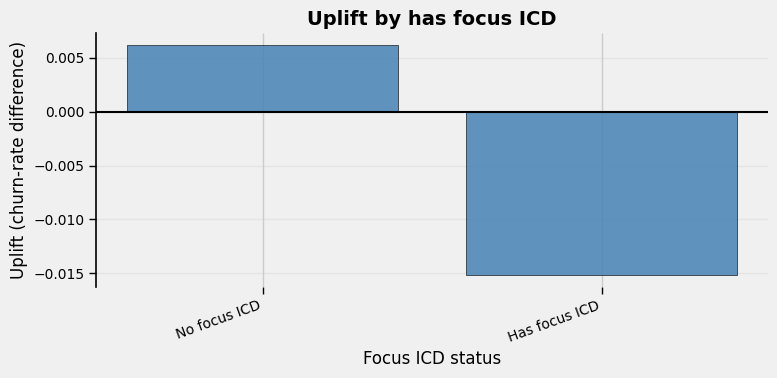

Group                       Uplift  n_treated  n_control
No focus ICD                0.0062        306        446
Has focus ICD              -0.0152       3678       5570


In [22]:
# Uplift by has focus ICD (binary: No / Yes)
uplift_by_groups(cl, labels, "has_focus_icd", [0, 1], plot_labels=["No focus ICD", "Has focus ICD"], title="Uplift by has focus ICD", xlabel="Focus ICD status")


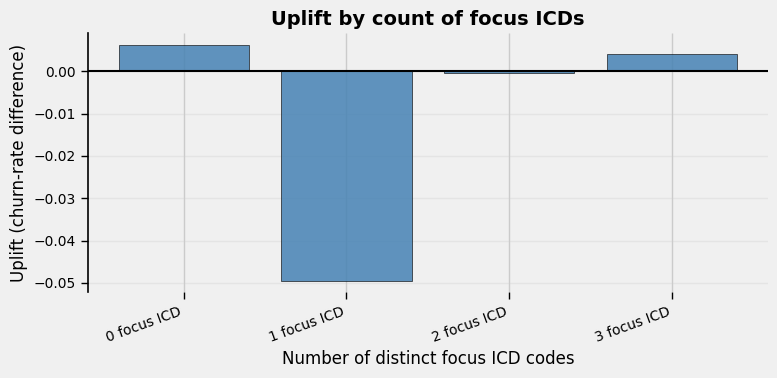

Group                       Uplift  n_treated  n_control
0 focus ICD                 0.0062        306        446
1 focus ICD                -0.0495       1152       1802
2 focus ICD                -0.0003       1685       2488
3 focus ICD                 0.0040        841       1280


In [23]:
# Uplift by count of focus ICDs (0, 1, 2, 3)
uplift_by_groups(cl, labels, "focus_icd_count", [0, 1, 2, 3], plot_labels=["0 focus ICD", "1 focus ICD", "2 focus ICD", "3 focus ICD"], title="Uplift by count of focus ICDs", xlabel="Number of distinct focus ICD codes")


**What it means:** Uplift by claims (count, focus ICD, quartiles) varies across groups; some segments show stronger or weaker outreach effects.

**What it says about further analysis:** Claims-based features are useful for targeting. 

### 3.10 Recency & tenure


In [24]:
recency_df, ref_date = build_recency_tenure(churn_labels, web_visits, app_usage, claims)
rec = churn_labels[['member_id', 'churn', 'outreach']].merge(recency_df, left_on='member_id', right_index=True)
print('Ref date:', ref_date)
print(f"Members: {len(rec)}")
print(rec[['days_since_last_web', 'days_since_last_app', 'days_since_last_activity', 'tenure_days']].describe().round(1).to_string())

Ref date: 2025-07-14 23:59:51
Members: 10000
       days_since_last_web  days_since_last_app  days_since_last_activity  tenure_days
count               9975.0               9998.0                   10000.0      10000.0
mean                   0.5                  1.0                       0.1        302.6
std                    1.2                  1.5                       0.3        149.3
min                    0.0                  0.0                       0.0         44.0
25%                    0.0                  0.0                       0.0        174.0
50%                    0.0                  1.0                       0.0        304.0
75%                    0.0                  2.0                       0.0        433.0
max                   13.0                 13.0                       5.0        560.0


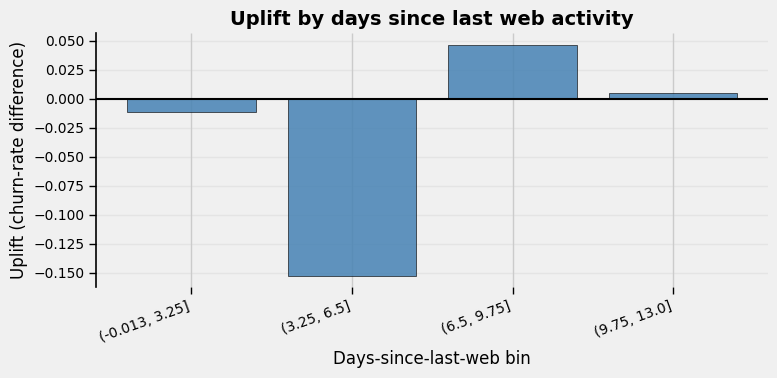

Group                       Uplift  n_treated  n_control
(-0.013, 3.25]             -0.0111       3863       5823
(3.25, 6.5]                -0.1525         69        126
(6.5, 9.75]                 0.0466         23         42
(9.75, 13.0]                0.0048         14         15
Excluded from plot (no web activity): 25 members (n too small for stable uplift).


In [25]:
# Uplift by days_since_last_web quartile
feat = "days_since_last_web"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last web activity", xlabel="Days-since-last-web bin")
print(f"Excluded from plot (no web activity): {excluded} members (n too small for stable uplift).")


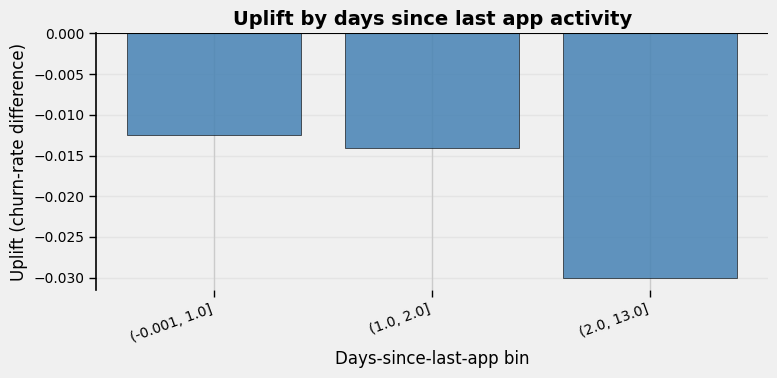

Group                       Uplift  n_treated  n_control
(-0.001, 1.0]              -0.0125       2780       4647
(1.0, 2.0]                 -0.0140        543        648
(2.0, 13.0]                -0.0300        659        721
Excluded from plot (no app activity): 2 members (n too small for stable uplift).


In [26]:
# Uplift by days_since_last_app quartile
feat = "days_since_last_app"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last app activity", xlabel="Days-since-last-app bin")
print(f"Excluded from plot (no app activity): {excluded} members (n too small for stable uplift).")


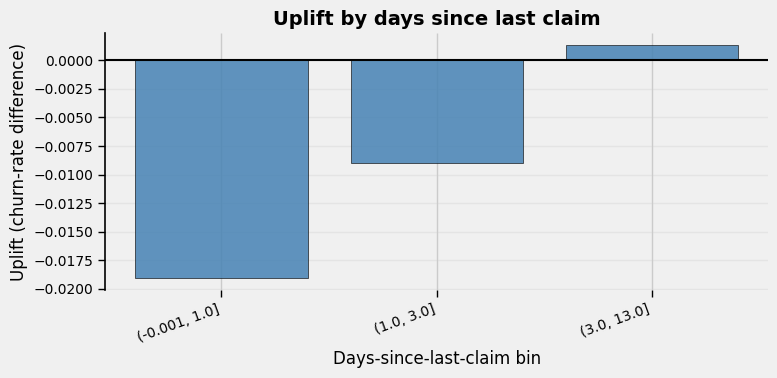

Group                       Uplift  n_treated  n_control
(-0.001, 1.0]              -0.0191       2356       3544
(1.0, 3.0]                 -0.0089        984       1480
(3.0, 13.0]                 0.0013        636        980
Excluded from plot (no claims): 20 members (n too small for stable uplift).


In [27]:
# Uplift by days_since_last_claim quartile
feat = "days_since_last_claim"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last claim", xlabel="Days-since-last-claim bin")
print(f"Excluded from plot (no claims): {excluded} members (n too small for stable uplift).")


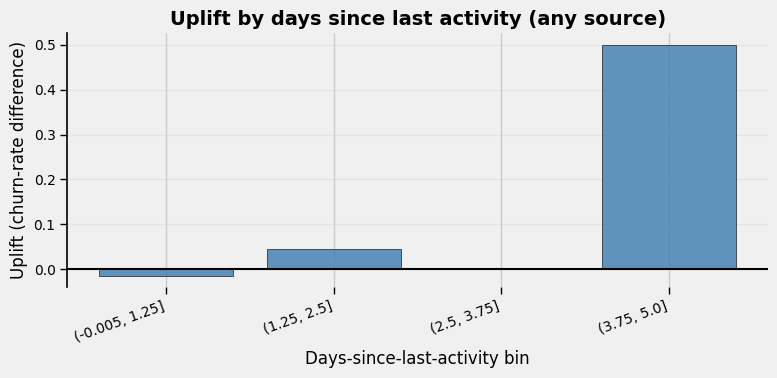

Group                       Uplift  n_treated  n_control
(-0.005, 1.25]             -0.0141       3934       5959
(1.25, 2.5]                 0.0460         43         49
(2.5, 3.75]                 0.0000          5          7
(3.75, 5.0]                 0.5000          2          1
Excluded from plot (no activity at all): 0 members (n too small for stable uplift).


In [28]:
# Uplift by days_since_last_activity quartile
feat = "days_since_last_activity"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last activity (any source)", xlabel="Days-since-last-activity bin")
print(f"Excluded from plot (no activity at all): {excluded} members (n too small for stable uplift).")


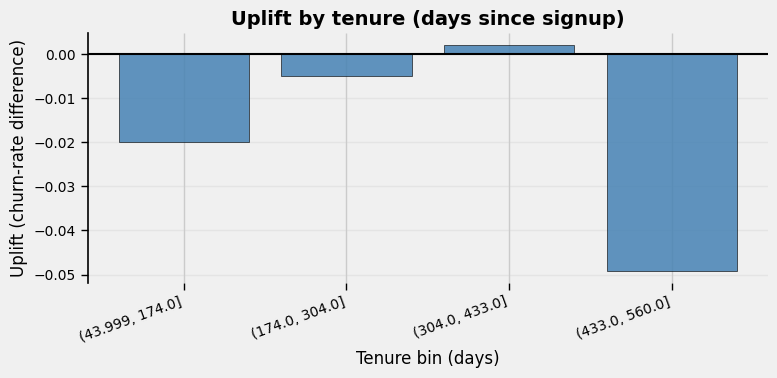

Group                       Uplift  n_treated  n_control
(43.999, 174.0]            -0.0200       1097       1426
(174.0, 304.0]             -0.0049        964       1532
(304.0, 433.0]              0.0021        968       1538
(433.0, 560.0]             -0.0493        955       1520
Excluded from plot (missing signup_date): 0 members (n too small for stable uplift).


In [29]:
# Uplift by tenure_days quartile
feat = "tenure_days"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by tenure (days since signup)", xlabel="Tenure bin (days)")
print(f"Excluded from plot (missing signup_date): {excluded} members (n too small for stable uplift).")


**What it means:** Uplift by recency and tenure bins shows how outreach effect varies with how recently members were active and how long they have been members.

**What it says about further analysis:** Recency and tenure are strong candidates for the uplift model. EDA is complete.

## 4. Feature Engineering
Config; load WellCo brief and embedding model once; then build train/test feature matrices (utils).


In [30]:
WELLCO_BRIEF_PATH = FILE_DIR / 'wellco_client_brief.txt'
print(f"Similarity threshold – {SIMILARITY_THRESHOLD}")
print(f"Embedding model      – {EMBED_MODEL_NAME}")
print(f"Focus ICD codes      – {FOCUS_ICD_CODES}")

Similarity threshold – 0.2
Embedding model      – all-MiniLM-L6-v2
Focus ICD codes      – ['E11.9', 'I10', 'Z71.3']


In [31]:
# ── RUN ONCE: load embedding model & embed WellCo brief ────────────────────
# This cell is intentionally isolated so it runs exactly once per session.
# All downstream cells reuse `embed_model` and `wellco_embedding`.

brief_text = load_wellco_brief(WELLCO_BRIEF_PATH)
embed_model = SentenceTransformer(EMBED_MODEL_NAME)
wellco_embedding = embed_wellco_brief(brief_text, embed_model)  # shape (1, dim)

print(f"WellCo brief loaded     – {len(brief_text):,} characters")
print(f"Embedding model loaded  – {EMBED_MODEL_NAME}")
print(f"WellCo embedding shape  – {wellco_embedding.shape}")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 441.81it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


WellCo brief loaded     – 1,946 characters
Embedding model loaded  – all-MiniLM-L6-v2
WellCo embedding shape  – (1, 384)


In [32]:
ref_date_train = ref_date_from_tables(web_visits, app_usage, claims)
ref_date_test  = ref_date_from_tables(test_web_visits, test_app_usage, test_claims)
print('ref_date_train:', ref_date_train, '| ref_date_test:', ref_date_test)

print('Building TRAIN feature matrix...')
train_features = build_feature_matrix(churn_labels, web_visits, app_usage, claims, ref_date_train,
    wellco_embedding=wellco_embedding, embed_model=embed_model, include_labels=True)
    
print('Building TEST feature matrix...')
test_features = build_feature_matrix(test_members, test_web_visits, test_app_usage, test_claims, ref_date_test,
    wellco_embedding=wellco_embedding, embed_model=embed_model, include_labels=False)

# --- Quick summary ----------------------------------------------------------
print(f"\nTrain features shape: {train_features.shape}")
print(f"Test  features shape: {test_features.shape}")
print(f"\nTrain columns: {list(train_features.columns)}")
print(f"Test  columns: {list(test_features.columns)}")
print(f"\nTrain head:\n{train_features.head()}")


ref_date_train: 2025-07-14 23:59:51 | ref_date_test: 2025-07-14 23:59:56
Building TRAIN feature matrix...
  embed_visit_texts: 26 unique texts embedded (from 259,340 rows)
Web relevance filter: 101,500 / 259,340 visits retained (threshold=0.2)
Building TEST feature matrix...
  embed_visit_texts: 26 unique texts embedded (from 261,729 rows)
Web relevance filter: 102,187 / 261,729 visits retained (threshold=0.2)

Train features shape: (10000, 12)
Test  features shape: (10000, 10)

Train columns: ['member_id', 'wellco_web_visits_count', 'days_since_last_wellco_web', 'app_sessions_count', 'days_since_last_app', 'claims_count', 'icd_distinct_count', 'has_focus_icd', 'days_since_last_claim', 'tenure_days', 'outreach', 'churn']
Test  columns: ['member_id', 'wellco_web_visits_count', 'days_since_last_wellco_web', 'app_sessions_count', 'days_since_last_app', 'claims_count', 'icd_distinct_count', 'has_focus_icd', 'days_since_last_claim', 'tenure_days']

Train head:
   member_id  wellco_web_visit

### 4.1 Feature diagnostics (informational only)
Inspect distributions and multicollinearity of the engineered features **on the training set**. This section is for review only — no features are automatically dropped or transformed.

In [33]:
# ── 4.6a  Per-feature distribution diagnostics ──────────────────────────────
# Feature columns only (exclude member_id and labels)
FEATURE_COLS = [
    "wellco_web_visits_count",
    # TOGGLE: uncomment next line to include URL feature in diagnostics
    # "wellco_web_unique_urls",
    "days_since_last_wellco_web",
    "app_sessions_count",
    "days_since_last_app",
    "claims_count",
    "icd_distinct_count",
    "has_focus_icd",
    "days_since_last_claim",
    "tenure_days",
]
feature_diagnostics(train_features, FEATURE_COLS, title_suffix="(train)")


FEATURE SUMMARY STATISTICS (train)
                              count        mean         std   min    25%    50%    75%    max
wellco_web_visits_count     10000.0   10.150000    7.766204   0.0    5.0    8.0   14.0   62.0
days_since_last_wellco_web   9788.0    1.489068    2.279756   0.0    0.0    1.0    2.0   13.0
app_sessions_count          10000.0    9.778900    3.627800   0.0    7.0   10.0   12.0   26.0
days_since_last_app          9998.0    1.048510    1.477363   0.0    0.0    1.0    2.0   13.0
claims_count                10000.0    6.457600    2.582028   0.0    5.0    6.0    8.0   18.0
icd_distinct_count          10000.0    4.653000    1.563021   0.0    4.0    5.0    6.0   10.0
has_focus_icd               10000.0    0.924800    0.263727   0.0    1.0    1.0    1.0    1.0
days_since_last_claim        9980.0    1.722946    2.086201   0.0    0.0    1.0    3.0   13.0
tenure_days                 10000.0  302.604700  149.312937  44.0  174.0  304.0  433.0  560.0

ZEROS AND MISSING VALUES

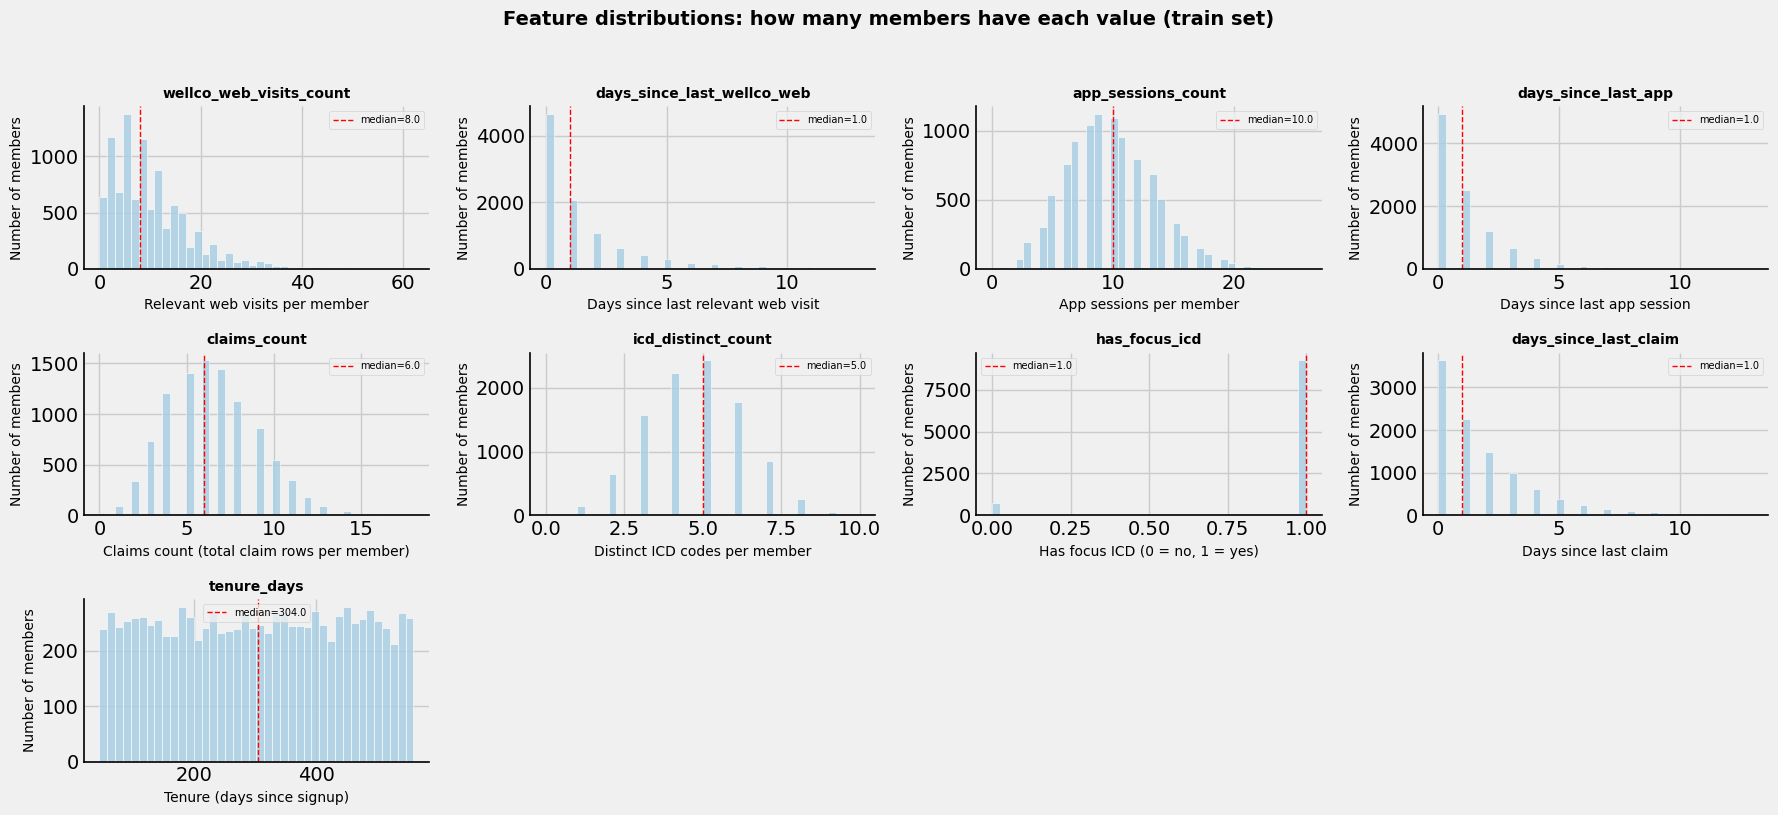

In [34]:
# ── 4.6b  Histograms ────────────────────────────────────────────────────────
# Each plot: x = feature value, y = how many members have that value.
FEATURE_XLABELS = {
    "wellco_web_visits_count": "Relevant web visits per member",
    "wellco_web_unique_urls": "Unique URLs (WellCo-relevant visits)",
    "days_since_last_wellco_web": "Days since last relevant web visit",
    "app_sessions_count": "App sessions per member",
    "days_since_last_app": "Days since last app session",
    "claims_count": "Claims count (total claim rows per member)",
    "icd_distinct_count": "Distinct ICD codes per member",
    "has_focus_icd": "Has focus ICD (0 = no, 1 = yes)",
    "days_since_last_claim": "Days since last claim",
    "tenure_days": "Tenure (days since signup)",
}
plot_feature_histograms(train_features, FEATURE_COLS, xlabels=FEATURE_XLABELS, suptitle="Feature distributions: how many members have each value (train set)")


**What we see in these distribution plots (train set):** Each histogram shows how many members have each value for one feature. For tree-based uplift models we use these as-is; for linear models we'd log1p skewed counts and keep binary 0/1.

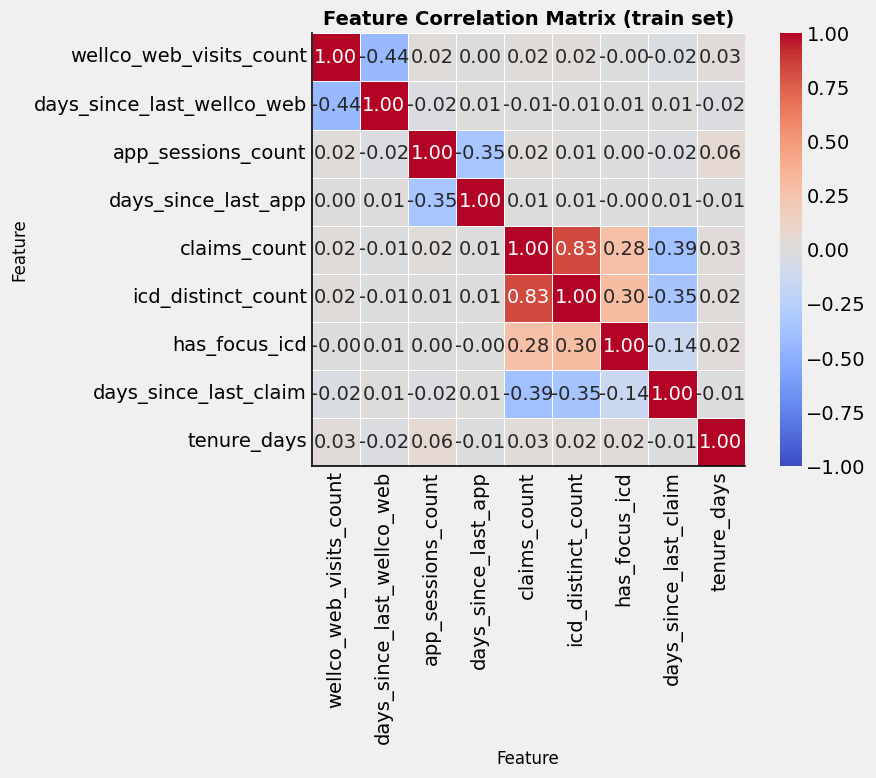


Pairs with |correlation| >= 0.8:
  claims_count  ↔  icd_distinct_count  :  r = 0.830


In [35]:
# ── 4.6c  Multicollinearity diagnostic ──────────────────────────────────────
plot_correlation_diagnostics(train_features, FEATURE_COLS, threshold=0.8, title_suffix="(train set)")


**What we see in this heatmap:** The plot above is the correlation matrix of the 9 feature columns (including `wellco_web_unique_urls`). The only pair with |r| ≥ 0.8 is **claims_count** and **icd_distinct_count**.  **Decision:** They aren't perfectly correlated but share information. I will keep them for now, choosing a tree based model with regularization as a base model.

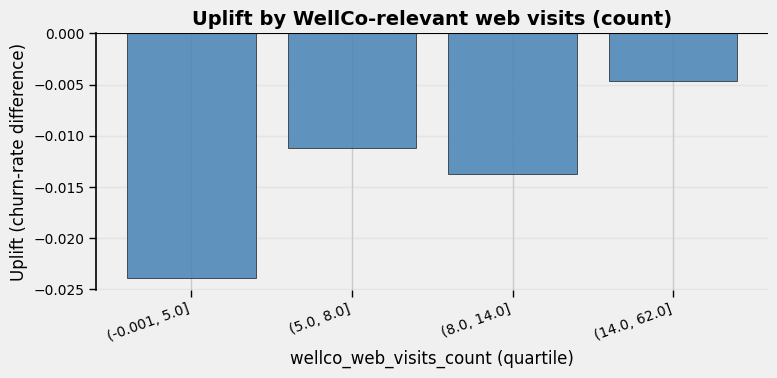

Group                       Uplift  n_treated  n_control
(-0.001, 5.0]              -0.0238       1284       1901
(5.0, 8.0]                 -0.0112        780       1118
(8.0, 14.0]                -0.0137       1023       1608
(14.0, 62.0]               -0.0046        897       1389


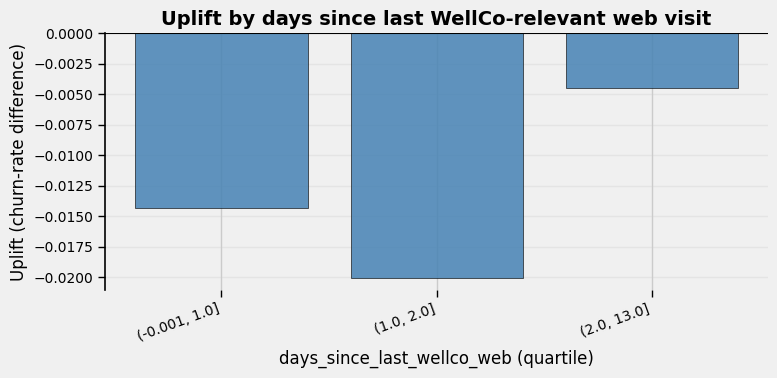

Group                       Uplift  n_treated  n_control
(-0.001, 1.0]              -0.0143       2646       4077
(1.0, 2.0]                 -0.0200        450        641
(2.0, 13.0]                -0.0045        810       1164
Excluded from plot (no relevant web visits): 212 members.


In [36]:
# ── 4.6d  Uplift by WellCo-relevant web features ───────────────────────────
# Uses uplift_by_groups with labels; train_features has the three web features.
web_uplift_df = train_features[["member_id", "wellco_web_visits_count", "days_since_last_wellco_web"]].copy()

# 1. Uplift by wellco_web_visits_count (quartiles)
web_uplift_df["quartile_bin"] = pd.qcut(web_uplift_df["wellco_web_visits_count"], q=4, duplicates="drop")
uplift_by_groups(web_uplift_df, labels, "quartile_bin", sorted(web_uplift_df["quartile_bin"].dropna().unique()), title="Uplift by WellCo-relevant web visits (count)", xlabel="wellco_web_visits_count (quartile)")

# 3. Uplift by days_since_last_wellco_web (quartiles); exclude members with no relevant visits
valid_web = web_uplift_df.dropna(subset=["days_since_last_wellco_web"]).copy()
n_excluded_web = len(web_uplift_df) - len(valid_web)
valid_web["quartile_bin"] = pd.qcut(valid_web["days_since_last_wellco_web"], q=4, duplicates="drop")
uplift_by_groups(valid_web, labels, "quartile_bin", sorted(valid_web["quartile_bin"].dropna().unique()), title="Uplift by days since last WellCo-relevant web visit", xlabel="days_since_last_wellco_web (quartile)")
print(f"Excluded from plot (no relevant web visits): {n_excluded_web} members.")


**What we see in these uplift plots:** Each bar chart bins members by quartiles of one WellCo-relevant web feature and shows the **uplift** (churn rate difference: control − treated) in that bin. **Plot 1 (wellco_web_visits_count):** Uplift is small and slightly negative across quartiles; more visits do not show a clearly stronger or weaker outreach effect here.  **Plot 2 (days_since_last_wellco_web):** Members with no relevant visit are excluded; across quartiles uplift is again modest. Overall, these filtered web features show some variation in uplift by segment but no single strong moderator; they remain useful as inputs to the uplift model rather than as standalone targeting rules.

### 4.2 Embeding + relevance filter sanity test
The 26 unique (title, description) pairs in the web data split into two groups based on the WellCo brief (nutrition, exercise, sleep, stress, diabetes, hypertension, cardiometabolic health). If the test passes, the threshold is separating relevant from non-relevant correctly on these unseen examples.

In [37]:
# 4.7 Relevance filter sanity test (logic in utils.run_relevance_filter_sanity_check)
run_relevance_filter_sanity_check(wellco_embedding, embed_model)

  embed_visit_texts: 9 unique texts embedded (from 9 rows)
Web relevance filter: 5 / 9 visits retained (threshold=0.2)
✓ All relevance-filter sanity checks passed.
  Member 10: 2 visits, 2 unique URLs
  Member 11: 3 visits, 3 unique URLs
  Member 12: 0 visits (correctly excluded)


## 5. Model Selection — Uplift CV

Compare all combinations of meta-learners (S, T, X) and base models (LightGBM, XGBoost) using member-level stratified K-fold CV. Metrics: **AUUC** (primary), **Qini** (secondary), **uplift@5%/10%/20%**. No automatic model choice; table and figures for write-up saved to disk. Default hyperparameters (tuning in the next section).


### 5.1 Setup for uplift CV

Define feature matrix **X**, labels **y**, treatment indicator, and candidate definitions (S/T/X × LGBM/XGB). Default hyperparameters; stratification by treatment and churn.

In [59]:
X = train_features[FEATURE_COLS].copy()
y = train_features["churn"].astype(int).values
treatment = train_features["outreach"].astype(int).values
scale_pos_weight = (y == 0).sum() / max((y == 1).sum(), 1)
N_SPLITS = 5
N_CURVE_POINTS = 100
CANDIDATE_DEFS = [
    ("S+LGBM", "S", "LGBM"),
    ("S+XGB", "S", "XGB"),
    ("T+LGBM", "T", "LGBM"),
    ("T+XGB", "T", "XGB"),
]
print(f"X shape: {X.shape} | Churn rate: {y.mean():.4f} | Treatment rate: {treatment.mean():.4f}")
print(f"Candidates: {[c[0] for c in CANDIDATE_DEFS]}")

X shape: (10000, 9) | Churn rate: 0.2021 | Treatment rate: 0.3984
Candidates: ['S+LGBM', 'S+XGB', 'T+LGBM', 'T+XGB']


### 5.2 Run CV

Stratified K-fold CV; uplift metrics (AUUC, Qini, uplift@5%/10%/20%) computed on validation folds using both treated and control samples.

In [60]:
cv_results = run_uplift_cv(
    X, y, treatment,
    candidate_defs=CANDIDATE_DEFS,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_curve_points=N_CURVE_POINTS,
    uplift_k_fracs=[0.05, 0.1, 0.2],
)
print(f"Completed {len(cv_results)} fold runs ({len(CANDIDATE_DEFS)} candidates × {N_SPLITS} folds).")
first = cv_results[0]
print(f"Fold sanity (example): n_val={first['n_val']}, n_treated_val={first['n_treated_val']}, n_control_val={first['n_control_val']}")

Completed 20 fold runs (4 candidates × 5 folds).
Fold sanity (example): n_val=2000, n_treated_val=796, n_control_val=1204


### 5.3 Comparison table

Mean ± std for AUUC, Qini, uplift@5%/10%/20%; fold sizes and treated/control counts as sanity check.

In [61]:
cv_summary = build_uplift_cv_comparison_table(cv_results)
display(cv_summary)

,candidate,auuc_mean,auuc_std,qini_mean,qini_std,uplift_at_k_5_mean,uplift_at_k_5_std,uplift_at_k_10_mean,uplift_at_k_10_std,uplift_at_k_20_mean,uplift_at_k_20_std,n_val_mean,n_treated_val_mean,n_control_val_mean
0,S+LGBM,0.015598,0.014477,0.093561,0.330814,0.016390,0.099285,0.015715,0.029589,0.012588,0.033825,2000.0,796.8,1203.2
1,S+XGB,0.023296,0.014194,0.109176,0.290077,0.081796,0.027457,0.039202,0.030110,0.021519,0.037608,2000.0,796.8,1203.2
2,T+LGBM,0.016826,0.009647,0.146949,0.213669,0.018164,0.069328,0.009160,0.031317,0.011759,0.024548,2000.0,796.8,1203.2
3,T+XGB,0.009864,0.019838,-0.232775,0.440864,0.016749,0.097361,0.029566,0.057521,0.004549,0.032445,2000.0,796.8,1203.2


### 5.4 Visualizations

(1) Mean AUUC with error bars by model. (2) Uplift@10% and uplift@20% by model. (3) Qini curves (mean over CV folds): random baseline and top 3 models.

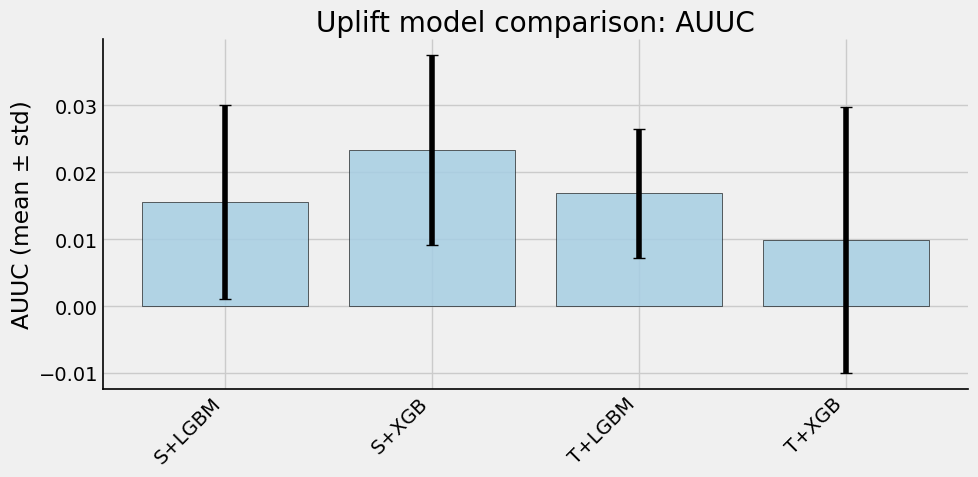

In [62]:
plot_auuc_comparison(cv_summary)
plt.show()

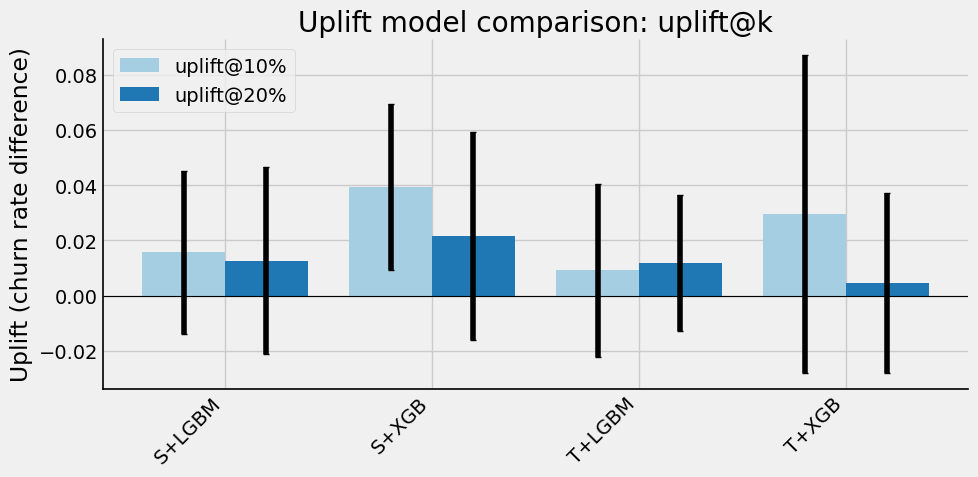

In [63]:
plot_uplift_at_k_comparison(cv_summary, k_fracs=[0.1, 0.2])
plt.show()

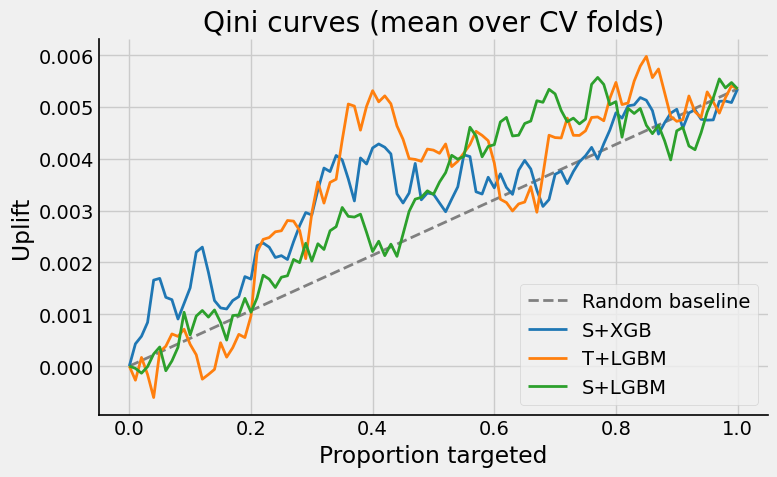

In [66]:
# Qini curves (mean over CV folds) for top 3 models + random baseline
curves = get_validation_qini_curves(
    X, y, treatment, CANDIDATE_DEFS, cv_summary,
    top_n=3, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
plot_qini_curves_comparison(curves)
plt.show()

### 5.5 Save report to disk

Save comparison table (CSV) and figures (PNG) for the write-up.

In [67]:
UPLIFT_REPORT_DIR = FILE_DIR / "uplift_cv_report"
save_uplift_cv_report(
    cv_summary,
    table_path=UPLIFT_REPORT_DIR / "uplift_cv_comparison.csv",
    figure_dir=UPLIFT_REPORT_DIR,
    cv_results=cv_results,
    X=X, y=y, treatment=treatment, candidate_defs=CANDIDATE_DEFS,
    top_n_curves=3, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
print(f"Table and figures saved to {UPLIFT_REPORT_DIR}")

Table and figures saved to C:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\files\uplift_cv_report


**Summary (Section 5).** All S/T × LGBM/XGB candidates were compared on uplift metrics (AUUC, Qini, uplift@5%/10%/20%). S+XGB was selected as the best candidate based on mean AUUC.

## 6. Hyperparameter Tuning — Grid Search (S+XGB)

Based on Section 5, **S-learner + XGBoost** was chosen as the best candidate. We now tune the XGBoost base-learner hyperparameters via exhaustive grid search, using the same stratified 5-fold CV and mean AUUC as the selection criterion.

### 6.1 Define the parameter grid

In [68]:
# Chosen candidate from Section 5
TUNING_META = "S"        # S-learner
TUNING_BASE = "XGB"      # XGBoost base learner

# XGBoost hyperparameter grid (regularization matters for uplift — CATE is noisier than outcomes)
# Subsample / colsample_bytree left at XGB default (1.0) to keep grid small and comparable.
HP_GRID = {
    # Tree complexity: shallow trees reduce overfitting of treatment-effect heterogeneity
    "max_depth": [3, 4, 5],
    # Learning: smaller LR + more trees often generalizes better
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [400, 800],
    # Leaf size: higher = fewer samples per leaf, more regularization
    "min_child_weight": [1, 5, 10],
    # L2 (reg_lambda): XGB default 1; 10 strengthens regularization
    "reg_lambda": [1, 5, 10],
    # L1 (reg_alpha): 0 = none; 0.1–1 encourage sparsity
    "reg_alpha": [0, 0.1, 1],
}

# Total combinations (run can take a while; subset grid below if needed for a quick pass)
n_combos = 1
for v in HP_GRID.values():
    n_combos *= len(v)
print(f"Parameter grid: {n_combos} combinations × {N_SPLITS} folds = {n_combos * N_SPLITS} model fits")

Parameter grid: 486 combinations × 5 folds = 2430 model fits


### 6.2 Run grid search

In [69]:
%%time
# Run exhaustive grid search — reuses the same X, y, treatment from Section 5
grid_results = run_uplift_hp_grid_search(
    X, y, treatment,
    meta_key=TUNING_META,
    base_key=TUNING_BASE,
    param_grid=HP_GRID,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_curve_points=N_CURVE_POINTS,
    uplift_k_fracs=[0.05, 0.1, 0.2],
)
print(f"\nGrid search complete: {len(grid_results)} fold-level results collected.")

  Grid search: 10/486 combos done (50 fits)
  Grid search: 20/486 combos done (100 fits)
  Grid search: 30/486 combos done (150 fits)
  Grid search: 40/486 combos done (200 fits)
  Grid search: 50/486 combos done (250 fits)
  Grid search: 60/486 combos done (300 fits)
  Grid search: 70/486 combos done (350 fits)
  Grid search: 80/486 combos done (400 fits)
  Grid search: 90/486 combos done (450 fits)
  Grid search: 100/486 combos done (500 fits)
  Grid search: 110/486 combos done (550 fits)
  Grid search: 120/486 combos done (600 fits)
  Grid search: 130/486 combos done (650 fits)
  Grid search: 140/486 combos done (700 fits)
  Grid search: 150/486 combos done (750 fits)
  Grid search: 160/486 combos done (800 fits)
  Grid search: 170/486 combos done (850 fits)
  Grid search: 180/486 combos done (900 fits)
  Grid search: 190/486 combos done (950 fits)
  Grid search: 200/486 combos done (1000 fits)
  Grid search: 210/486 combos done (1050 fits)
  Grid search: 220/486 combos done (1100 f

### 6.3 Comparison table

Mean ± std across folds for each hyperparameter combination, sorted by descending mean AUUC.

In [70]:
# Build and display the comparison table (sorted by mean AUUC descending)
grid_summary = build_hp_grid_search_table(grid_results)
print(f"Top 10 of {len(grid_summary)} hyperparameter combinations:\n")
display(grid_summary.head(10))

Top 10 of 486 hyperparameter combinations:



,params_str,auuc_mean,auuc_std,qini_mean,qini_std,uplift_at_k_5_mean,uplift_at_k_5_std,uplift_at_k_10_mean,uplift_at_k_10_std,uplift_at_k_20_mean,uplift_at_k_20_std
0,"learning_rate=0.05, max_depth=3, min_child_wei...",0.028437,0.008907,0.173927,0.227257,0.068887,0.048265,0.045209,0.028364,0.051999,0.013163
1,"learning_rate=0.03, max_depth=3, min_child_wei...",0.027628,0.007536,0.146318,0.213901,0.040660,0.026391,0.051734,0.036189,0.049765,0.021909
2,"learning_rate=0.05, max_depth=5, min_child_wei...",0.027378,0.010369,0.273923,0.141014,0.072750,0.067089,0.031454,0.032917,0.030865,0.027904
3,"learning_rate=0.03, max_depth=5, min_child_wei...",0.027352,0.009111,0.153665,0.172943,0.072656,0.052454,0.053584,0.028293,0.034597,0.024376
4,"learning_rate=0.1, max_depth=3, min_child_weig...",0.027331,0.004961,0.188155,0.132878,0.045544,0.037963,0.045339,0.017714,0.050046,0.007416
5,"learning_rate=0.03, max_depth=3, min_child_wei...",0.026828,0.009636,0.109801,0.259993,0.056959,0.016262,0.045046,0.029793,0.054815,0.018849
6,"learning_rate=0.03, max_depth=3, min_child_wei...",0.026803,0.007944,0.126838,0.216101,0.048778,0.031275,0.052194,0.025340,0.053237,0.026679
7,"learning_rate=0.05, max_depth=5, min_child_wei...",0.026714,0.005872,0.159437,0.235270,0.066418,0.059869,0.047851,0.040008,0.035328,0.019924
8,"learning_rate=0.03, max_depth=5, min_child_wei...",0.026670,0.007271,0.212212,0.126139,0.058817,0.048874,0.039930,0.020347,0.049100,0.018333
9,"learning_rate=0.05, max_depth=3, min_child_wei...",0.026619,0.007426,0.175283,0.232988,0.082702,0.041844,0.019749,0.038278,0.047254,0.011555


In [71]:
# Best hyperparameter combination
best_row = grid_summary.iloc[0]
print("Best hyperparameters (by mean AUUC):")
print(f"  {best_row['params_str']}")
print(f"  AUUC  = {best_row['auuc_mean']:.6f} ± {best_row['auuc_std']:.6f}")
print(f"  Qini  = {best_row['qini_mean']:.6f} ± {best_row['qini_std']:.6f}")

Best hyperparameters (by mean AUUC):
  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=400, reg_alpha=1, reg_lambda=1
  AUUC  = 0.028437 ± 0.008907
  Qini  = 0.173927 ± 0.227257


### 6.4 Visualization

Qini curves (mean over CV folds) for the top 10 hyperparameter combinations.

c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\src\utils.py:2001: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


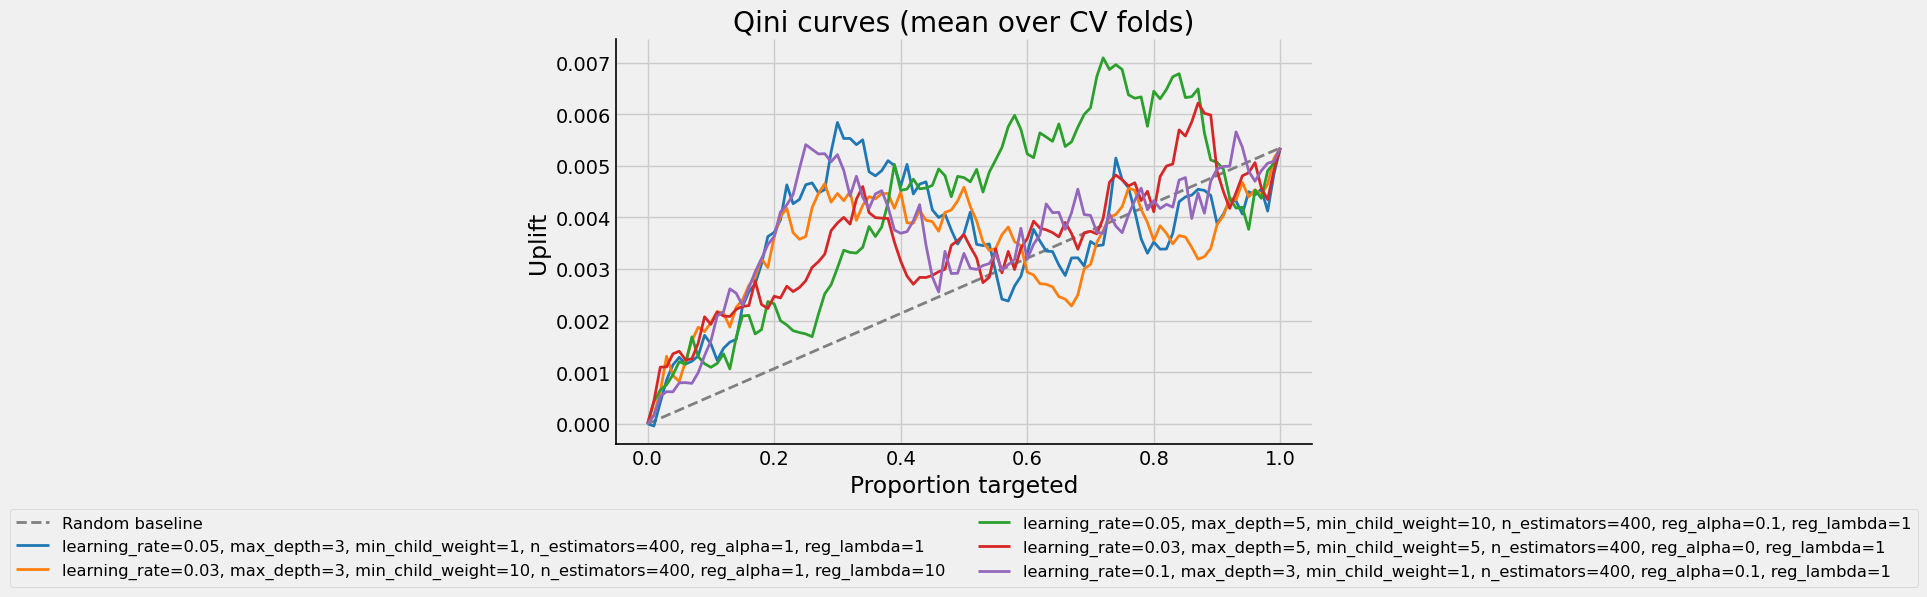

In [78]:
# Qini curves (mean over CV folds) for top 10 hyperparameter combos
hp_qini_curves = get_qini_curves_top_hp_combos(
    X, y, treatment, grid_summary, grid_results,
    meta_key=TUNING_META, base_key=TUNING_BASE, param_grid=HP_GRID,
    top_n=5, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
plot_qini_curves_comparison(hp_qini_curves)
plt.show()

### 6.5 Save grid-search report to disk

In [76]:
HP_REPORT_DIR = FILE_DIR / "hp_grid_search_report"
save_hp_grid_search_report(
    grid_summary,
    table_path=HP_REPORT_DIR / "hp_grid_search_results.csv",
    figure_dir=HP_REPORT_DIR,
    qini_curves=hp_qini_curves,
)
print(f"Grid-search table and figure saved to {HP_REPORT_DIR}")

Grid-search table and figure saved to C:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\files\hp_grid_search_report


**Summary (Section 6).** Exhaustive grid search over XGBoost hyperparameters was performed for the S+XGB uplift model using the same stratified 5-fold CV. The best combination was selected by mean AUUC. Full results table (CSV) and Qini curves (top 10 combos, mean over folds) are saved to disk.